In [1]:
import torch_geometric
torch_geometric.__version__

/mnt/home/zhuang/.conda/envs/bayesian_reweighting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.4.0'

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
%matplotlib inline
import math
import copy
from utils import read_dataset
from utils import SENSOR_COLUMNS, OP_SETTING_COLUMNS

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import cluster
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, ConcatDataset
from torch import nn
from torch import optim as optim
from torch.nn.utils import spectral_norm
from torch.nn.utils import weight_norm
from typing import Optional
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.nn import GATConv, GCNConv, BatchNorm
from torch_geometric import utils

import gpytorch
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, RQKernel, MaternKernel, ScaleKernel
from gpytorch.means import ConstantMean
from gpytorch.models import ApproximateGP

from gpytorch.variational import (
    CholeskyVariationalDistribution,
    IndependentMultitaskVariationalStrategy,
    VariationalStrategy,
)
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
from torch_geometric.nn.dense.linear import Linear


## Preprocessing

In [5]:
def calculate_RUL(X, upper_threshold=None):
    '''
    Calculate Remaining Useful Life per `unit`

    Parameters
    ----------
    X : pd.DataFrame, with `unit` and `time_cycles` columns
    upper_threshold: int, limit maximum RUL valus, default is None

    Returns
    -------
    np.array with Remaining Useful Life values
    '''
    lifetime = X.groupby(['unit'])['time_cycles'].transform(max)
    rul = lifetime - X['time_cycles']

    if upper_threshold:
        rul = np.where(rul > upper_threshold, upper_threshold, rul)

    return rul

In [6]:
class ScalePerEngine(BaseEstimator, TransformerMixin):
    '''
    Scale individual engines time series with respect to its start.
    Substract firts `n_first_cycles` AVG values from time series. 
    '''
    def __init__(self, n_first_cycles=20, sensors_columns=SENSOR_COLUMNS):
        self.n_first_cycles = n_first_cycles
        self.sensors_columns = sensors_columns
    
    def fit(self, X):
        return self

    def transform(self, X):
        init_sensors_avg = X[X['time_cycles'] <= self.n_first_cycles] \
            .groupby(by=['unit'])[self.sensors_columns] \
            .mean() \
            .reset_index()

        X_t = X[X['time_cycles'] > self.n_first_cycles].merge(
            init_sensors_avg,
            on=['unit'], how='left', suffixes=('', '_init_v')
        )

        for SENSOR in self.sensors_columns:
            X_t[SENSOR] = X_t[SENSOR] - X_t['{}_init_v'.format(SENSOR)]

        drop_columns = X_t.columns.str.endswith('init_v')
        return X_t[X_t.columns[~drop_columns]]

In [7]:
class LowVarianceFeaturesRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0, op_settings_col=OP_SETTING_COLUMNS, sensors_col=SENSOR_COLUMNS):
        self.threshold = threshold
        self.selector = VarianceThreshold(threshold=threshold)

    def fit(self, X):
        if "rul" in X.keys():
            self.selector.fit(X.drop(columns=['rul']))
        else:
            self.selector.fit(X)    
        
        return self

    def transform(self, X):
        rul = None
        if "rul" in X.keys():
            rul = X['rul']
            X = X.drop(columns=['rul'])
        X_t = self.selector.transform(X)
        droped_features = X.columns[~self.selector.get_support()]
        print(f'Droped low variance features: {droped_features.to_list()}')
        X_t = pd.DataFrame(X_t, columns=self.selector.get_feature_names_out())
        if rul is not None:
            X_t['rul'] = rul
        return X_t

In [8]:
class ScalePerOpSetting(BaseEstimator, TransformerMixin):
    def __init__(self, n_conditions=6, op_settings_col=OP_SETTING_COLUMNS, sensors_col=SENSOR_COLUMNS):
        self.n_conditions = n_conditions
        self.op_settings_col = op_settings_col
        self.sensors_col = sensors_col

    def fit(self, X):
        # scale before clustering
        self.kmeans_scaler = StandardScaler()
        X_sc = self.kmeans_scaler.fit_transform(X[self.op_settings_col])
        
        # cluster operational settings into `n_conditions` clusters
        self.kmeans = KMeans(n_clusters=self.n_conditions)
        self.kmeans.fit(X_sc)
        
        X_t = X.copy()
        X_t['op_set_cluster'] = self.kmeans.predict(X_sc)
        
        # scale per cluster
        self.scalers = {}
        for cluster in range(self.n_conditions):
            scaler = StandardScaler()
            scaler.fit(X_t[X_t['op_set_cluster'] == cluster][self.sensors_col])
            self.scalers[cluster] = scaler

        return self
    
    def transform(self, X):
        X_t = X.copy()
        X_t['op_set_cluster'] = self.kmeans.predict(
            self.kmeans_scaler.transform(X[self.op_settings_col]))

        set_columns = ['unit', 'time_cycles', 'op_set_cluster'] + self.op_settings_col
        df = pd.DataFrame()
        for cluster in range(self.n_conditions):
            cluster_X = X_t[X_t['op_set_cluster'] == cluster]
            scaler = self.scalers[cluster]
            sensors_sc = scaler.transform(cluster_X[self.sensors_col])
            if 'rul' in X_t.keys():
                df = df.append(pd.concat([cluster_X[set_columns].reset_index(drop=True), 
                                        pd.DataFrame(sensors_sc, columns=self.sensors_col),
                                        cluster_X['rul'].reset_index(drop=True)
                                        ], axis=1, ignore_index=True), 
                            ignore_index=True)
            else:    
                df = df.append(pd.concat([cluster_X[set_columns].reset_index(drop=True), 
                                        pd.DataFrame(sensors_sc, columns=self.sensors_col)
                                        ], axis=1, ignore_index=True), 
                            ignore_index=True)
        if 'rul' in X_t.keys():        
            df.columns = set_columns + SENSOR_COLUMNS + ["rul"]
        else:
            df.columns = set_columns + SENSOR_COLUMNS
        df = df.sort_values(['unit', 'time_cycles']).reset_index(drop=True)
        return df

In [9]:
class ScaleNormalization(BaseEstimator, TransformerMixin):
    def __init__(self, sensors_col=SENSOR_COLUMNS):
        self.sensors_col = sensors_col
        self.min_max_scaler = preprocessing.MinMaxScaler()
    def fit(self, X):
        X_t = X.copy()
        self.min_max_scaler.fit(X_t[self.sensors_col].values) 
        return self
    def transform(self, X): 
        X_t = X.copy()
        X_sc_v = self.min_max_scaler.transform(X_t[self.sensors_col].values) 
        X_t[self.sensors_col] = X_sc_v
        return X_t

## Visualization

In [10]:
def plot_all_units_per_dataset(df_train, dt_test, columns=SENSOR_COLUMNS, y_lim=None):
    datasets_train = df_train
    datasets_test = dt_test
    fd_name = ["Train","Test"]
    fig, ax = plt.subplots(21, 2, figsize=(26, 70))
    for i in range(2):
        if i == 0:
            datasets = datasets_train
        if i == 1: 
            datasets = datasets_test   
        for j, sensor in enumerate(columns):
            if sensor not in datasets_train.keys():
                continue
            datasets.pivot(index='time_cycles', columns='unit', values=sensor) \
                .plot(ax=ax[j,i], legend=None, alpha=0.5)
            ax[j,i].set_title('{} - {}, across all units'.format(fd_name[i], sensor))
            ax[j,i].grid(color='grey', linewidth=0.3)
            if y_lim is not None:
                ax[j,i].set_ylim(y_lim)
    fig.tight_layout()
    plt.show()

In [11]:
def engine_visualization(train_data, train_sc, engine_a, engine_b, selected_sensors, dataset_names=['FD001']):
    first_avg_values = (train_data[train_data['time_cycles'] <= 20]
    .groupby(by=[ 'unit'])[selected_sensors]
    .mean()
    .reset_index()
    )

    fig, ax = plt.subplots(len(selected_sensors), 2, figsize=(14, 20))
    for j, sensor in enumerate(selected_sensors):
            avg_sorted = (first_avg_values.sort_values(sensor))
            engine_a, engine_b = avg_sorted['unit'].iloc[0], avg_sorted['unit'].iloc[-1]
            for i, df in enumerate([train_data, train_sc]):
                sns.lineplot(
                    data=df[ (df['unit'].isin([engine_a, engine_b]))
                    ],
                    x='time_cycles', y=sensor, hue='unit', palette='tab10',
                    ax=ax[j, i]
                )
                ax[j, i].set_xlabel('')
                ax[j, i].set_title(f' {sensor}')
                ax[j, i].grid()
    return fig

## Evalution

In [12]:
def rul_score_f(err):
    if err >= 0:
        return np.exp(err / 10) - 1
    else:
        return np.exp(- err / 13) - 1

# Why this metric is a sum? Why not average?
# it means the metric increases with the size of the dataset
# and it means that it's not comparable between datasets
# of different sizes
def rul_score(true_rul, estimated_rul): 
    err = estimated_rul - true_rul
    if isinstance(err, torch.Tensor):
        err = err.cpu().numpy()
    return np.sum([rul_score_f(x) for x in err])

def rul_metrics_scorer(pred_rul, true_rul, metrics='all'):
    '''
    Calculate evaluation metrics:
        1. rmse - Root Mean Squared Error
        2. mae - Mean Absolute Error
        3. mape - Mean Absolute Percentage Error
        4. score - Custom metric with higher weight on underestimated RUL

    Returns
    -------
    dict with metrics
    '''
    scores_f = {
        'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error,
        'mape': mean_absolute_percentage_error,
        'score': rul_score
    }

    def calculate_scores(metrics_list):
        return {m: scores_f[m](true_rul, pred_rul) for m in metrics_list}

    if metrics == 'all':
        return calculate_scores(scores_f.keys())
    elif isinstance(metrics, list):
        return calculate_scores(metrics)

## Torch Dataset Creation

In [13]:
class Turbofandataset(Dataset):
    def __init__(self, mode='train', max_rul=135, window_size = 30, dataset=None, rul_result=None):
        self.mode = mode
        self.data_df = dataset
        if self.mode == 'train':
            self.rul_result = dataset['rul'].values
            dataset_new = dataset.drop(columns=['rul', 'time_cycles'])
        else:
            dataset_new = dataset.drop(columns=['time_cycles']) 
        self.data = dataset_new.values
        self.window_size = window_size
        self.engine_num = int(self.data[-1][0])
        self.length = []

        self.max_rul = max_rul

        if self.mode == 'test' and rul_result is not None:
            self.rul_result = rul_result
        if self.mode == 'test' and rul_result is None:
            raise ValueError('You did not specify the rul_result file path of the testset, '
                             'please check if the parameters you passed in are correct.')
        if self.mode != 'test' and self.mode != 'train':
            raise ValueError('You chose an undefined mode, '
                             'please check if the parameters you passed in are correct.')
        if self.mode == 'train' and rul_result is not None:
            warnings.warn('This rul_result file will only be used in the test set, '
                          'and the current mode you selected is training, so the file will be ignored.')

        self.x = []
        self.mean_and_coef = []
        self.y = []
        self.rul = []
        self.x_df = []
        self.start_column_idx = 1
        if "op_set_cluster" in self.data_df.keys():
            self.start_column_idx = 2
  
        if self.mode == 'train':
            for i in range(1, self.engine_num + 1):
                data_temp = self.data_df[self.data_df["unit"]==i]
                data_temp_x = data_temp.drop(columns=['rul', 'time_cycles'])
                for j in range(len(data_temp) - self.window_size + 1):
                    self.y.append(data_temp["rul"].values[j+self.window_size-1])
                    self.x.append(data_temp_x.values[j: j+self.window_size, self.start_column_idx:])  
        if self.mode == 'test':
            for i in range(1, self.engine_num + 1):
                data_temp = self.data_df[self.data_df["unit"]==i]
                data_temp_x = data_temp.drop(columns=['time_cycles'])
                '''
                    When the number of data for a turbofan engine on the testset is less than the window length, 
                    an interpolation operation will be performed
                '''
                if len(data_temp) < self.window_size:
                    data = np.zeros((self.window_size, data_temp_x.shape[1]))
                    for j in range(data.shape[1]):
                        x_old = np.linspace(0, len(data_temp_x)-1, len(data_temp_x), dtype=np.float64)
                        params = np.polyfit(x_old, data_temp_x.values[:, j].flatten(), deg=1)
                        k = params[0]
                        b = params[1]
                        x_new = np.linspace(0, self.window_size-1, self.window_size, dtype=np.float64)
                        data[:, j] = (x_new * len(data_temp_x) / self.window_size * k + b)
                    self.x.append(data[-self.window_size:, self.start_column_idx:])
                else:
                    self.x.append(data_temp_x.values[-self.window_size:, self.start_column_idx:])
                rul = self.rul_result[i - 1]
                if rul > self.max_rul:
                    rul = self.max_rul
                self.y.append(rul)

        self.x = np.array(self.x)
        self.y = np.array(self.y)/self.max_rul
        for i in range(len(self.x)):
            one_sample = self.x[i]
            self.mean_and_coef.append(self.fea_extract(one_sample))

        mu = np.mean(self.mean_and_coef, axis=0)
        sigma = np.std(self.mean_and_coef, axis=0)
        eps = 1e-10
        self.mean_and_coef = (self.mean_and_coef - mu) / (sigma + eps)
        self.mean_and_coef = np.array(self.mean_and_coef)

    @staticmethod
    def fea_extract(data):
        fea = []
        x = np.array(range(data.shape[0]))
        for i in range(data.shape[1]):
            fea.append(np.mean(data[:, i]))
            fea.append(np.polyfit(x.flatten(), data[:, i].flatten(), deg=1)[0])
        return fea

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        x_tensor = torch.from_numpy(self.x[index]).to(torch.float32)
        y_tensor = torch.Tensor([self.y[index]]).to(torch.float32)
        handcrafted_features = torch.from_numpy(self.mean_and_coef[index]).to(torch.float32)
        return x_tensor, handcrafted_features, y_tensor

## Model layers
### AttentionLayer

In [14]:
class Attention3dBlock(nn.Module):
    def __init__(self, in_features=30, out_features=30):
        super(Attention3dBlock, self).__init__()
        self.in_features=in_features
        self.out_features=out_features
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=self.out_features),
            nn.Sigmoid(),
            nn.Softmax(dim=2),
        )
        self.x_probs_exp = None 
        self.count = 0

    # inputs: batch size * window size(time step) * sensor channel dims
    def forward(self, inputs):
        #print(inputs.shape, self.in_features, self.out_features)
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        #print(x.shape)
        x_probs = x.permute(0, 2, 1)
        #print(torch.sum(x_probs))
        #print(inputs.shape, x_probs.shape)
        self.x_probs_exp = x_probs#[0].T
        #print(self.x_probs_exp.shape)
        #print(x_probs.shape,inputs.shape )
        output =  inputs * x_probs
        #print(inputs.shape, output.shape)
        return output

class TemporalAttention(nn.Module):
    def __init__(self, in_features=30, out_features=30):
        super(TemporalAttention, self).__init__()
        self.in_features=in_features
        self.out_features=out_features
        self.linear = nn.Linear(in_features=self.in_features, out_features=self.out_features)
        torch.nn.init.xavier_uniform(self.linear.weight)
        self.act = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=2)
        self.x_probs = None


    # inputs: batch size * window size(time step) * sensor channel dims
    def forward(self, inputs):
        #print(inputs.shape, self.in_features, self.out_features)
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x = self.act(x)
        #print(x.shape)
        
        #print(torch.sum(x_probs))
        #print(inputs.shape, x_probs.shape)
        x = self.softmax(x)
        self.x_probs = x.permute(0, 2, 1)
        #print(self.x_probs_exp.shape)
        #print(x_probs.shape,inputs.shape )

        # fig = plt.figure(figsize=(15,15))
        # plt.matshow(x_probs[10].cpu().detach().numpy().T)
        # plt.ylabel("Sensor ID", fontsize=15)
        # plt.xlabel("Time Steps", fontsize=15)
        # plt.xticks(fontsize=15)
        # plt.yticks(fontsize=15)
        # plt.tight_layout()
        # #plt.savefig(os.path.join('./', f'image/Tempro_Attention{randint(0,100)}.pdf'))
        # plt.show()
        output =  inputs * self.x_probs
        
        return output

## TCN Layer

In [15]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
    
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class AttentionTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(AttentionTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [
                       TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)
                       #, Attention3dBlock(out_channels, out_channels)
                       ,TemporalAttention(out_channels,out_channels)
                     ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class SpectralTemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(SpectralTemporalBlock, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = spectral_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class SpectralTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(SpectralTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [SpectralTemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class AttentionTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(AttentionTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)
                       #, Attention3dBlock(out_channels, out_channels)
                       ,TemporalAttention(out_channels,out_channels)
                      ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class AttentionSpectralTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(AttentionSpectralTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [SpectralTemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)
                       #, Attention3dBlock(out_channels, out_channels)
                       ,TemporalAttention(out_channels,out_channels)
                      ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)




## GNN Layer

In [16]:
class ResidualGraphBlock(torch.nn.Module):
    def __init__(self,
        in_channels: int,
        out_channels: int):
        super(ResidualGraphBlock, self).__init__()
        self.gcn_conv = GCNConv(in_channels, out_channels)
        self.residual = nn.Linear(in_channels, out_channels, bias=False)
    def forward(self, x, edge_index, edge_weight=None):
        out = self.gcn_conv(x, edge_index, edge_weight)
        if x.size(-1) != out.size(-1):
            x_res = self.residual(x)
        else:
            x_res = x
        return out + x_res
        
class AttentationResidualGraphBlock(torch.nn.Module):
    def __init__(self,
        in_channels: int,
        out_channels: int,
        heads: int):
        super(AttentationResidualGraphBlock, self).__init__()
        #如果想使用动态邻接矩阵， 除了forward使用edge_attr以外， 在初始化时edge_dim不能为None！， 否则不起作用
        #edge_attr 和 edge_weight的区别在于edge_weight是一维的。edge_attr可以是多维的， 也就是每个edge可以有多维的特征， 这时候你就需要定义edge_dim
        self.gcn_conv = GATConv(in_channels, out_channels, heads=heads, concat=False, dropout=0.0, edge_dim=1)
        self.residual = nn.Linear(in_channels, out_channels, bias=False)
    def forward(self, x, edge_index, edge_weight=None):
        out = self.gcn_conv(x, edge_index, edge_attr=edge_weight)
        if x.size(-1) != out.size(-1):
            x_res = self.residual(x)
        else:
            x_res = x
        return out + x_res
        
class GraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(GraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(in_feats, h_feats,  dropout=self.dropout)
        self.conv2 = GCNConv(h_feats, out_feats,  dropout=self.dropout)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x


class AttentionGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentionGraphConvNet, self).__init__()
        self.dropout = dropout
        #如果想使用动态邻接矩阵， 除了forward使用edge_attr以外， 在初始化时edge_dim不能为None！， 否则不起作用
        #edge_attr 和 edge_weight的区别在于edge_weight是一维的。edge_attr可以是多维的， 也就是每个edge可以有多维的特征， 这时候你就需要定义edge_dim
        self.conv1 = GATConv(in_feats, h_feats, heads=4, concat=False, dropout=self.dropout, edge_dim=1)
        self.conv2 = GATConv(h_feats, out_feats, heads=1, concat=False, dropout=self.dropout,edge_dim=1)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_attr=edge_weight))
        x = self.conv2(x, edge_index, edge_attr=edge_weight)
        return x

class SpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(SpectralGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(in_feats, h_feats,  dropout=self.dropout)
        self.conv1.lin = spectral_norm(self.conv1.lin)
        self.conv2 = GCNConv(h_feats, out_feats,  dropout=self.dropout)
        self.conv2.lin = spectral_norm(self.conv2.lin)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class AttentionSpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentionSpectralGraphConvNet, self).__init__()
        self.dropout = dropout
        #如果想使用动态邻接矩阵， 除了forward使用edge_attr以外， 在初始化时edge_dim不能为None！， 否则不起作用
        #edge_attr 和 edge_weight的区别在于edge_weight是一维的。edge_attr可以是多维的， 也就是每个edge可以有多维的特征， 这时候你就需要定义edge_dim
        self.conv1 = GATConv(in_feats, h_feats, heads=4, concat=False, dropout=self.dropout, edge_dim=1)
        self.conv1.lin_src = spectral_norm(self.conv1.lin_src)
        self.conv1.lin_dst = self.conv1.lin_dst
        self.conv2 = GATConv(h_feats, out_feats, heads=4, concat=False, dropout=self.dropout, edge_dim=1)
        self.conv2.lin_src = spectral_norm(self.conv2.lin_src)
        self.conv2.lin_dst = self.conv2.lin_dst
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_attr=edge_weight))
        x = self.conv2(x, edge_index, edge_attr=edge_weight)
        return x
        
class ResidualSpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(ResidualSpectralGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = ResidualGraphBlock(in_feats, h_feats)
        self.conv1.gcn_conv.lin = spectral_norm(self.conv1.gcn_conv.lin)
        self.conv2 = ResidualGraphBlock(h_feats, out_feats)
        self.conv2.gcn_conv.lin = spectral_norm(self.conv2.gcn_conv.lin)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x
   
class AttentationResidualSpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentationResidualSpectralGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = AttentationResidualGraphBlock(in_feats, h_feats, heads=4)
        self.conv1.gcn_conv.lin_src = spectral_norm(self.conv1.gcn_conv.lin_src)
        self.conv1.gcn_conv.lin_dst = self.conv1.gcn_conv.lin_src
        self.conv2 = AttentationResidualGraphBlock(h_feats, out_feats, heads=1)
        self.conv2.gcn_conv.lin_src = spectral_norm(self.conv2.gcn_conv.lin_src)
        self.conv2.gcn_conv.lin_dst = self.conv2.gcn_conv.lin_src
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class AttentationResidualGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentationResidualGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = AttentationResidualGraphBlock(in_feats, h_feats, heads=4)
        self.conv2 = AttentationResidualGraphBlock(h_feats, out_feats, heads=1)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x
        
class LearnableAdjacencyMatrix_PDAM(nn.Module):
    def __init__(self, num_nodes, init_edge_index=None):
        super(LearnableAdjacencyMatrix_PDAM, self).__init__()
        # 初始化邻接矩阵，这里我们使用0到1之间的随机值
        # 注意：根据你的需求，初始化方法可能需要调整
        if init_edge_index is not None:
            adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
            adj_matrix[init_edge_index[0], init_edge_index[1]] = 1
            self.adjacency_matrix = nn.Parameter(adj_matrix)
        else:    
            self.adjacency_matrix = nn.Parameter(torch.randn(num_nodes, num_nodes))
        self.act = nn.ReLU()
        #self.act = nn.Tanh()
    def forward(self):
        # 你可以在这里添加必要的处理步骤，比如将矩阵变成稀疏矩阵
        # 或者应用一些约束（例如，通过sigmoid函数将值限制在0和1之间）
        adjacency_matrix_processed = self.act(self.adjacency_matrix)
        
        # 返回处理后的邻接矩阵
        return adjacency_matrix_processed

class LearnableAdjacencyMatrix_IDAM(nn.Module):
    def __init__(self, in_features, out_features, alpha):
        super(LearnableAdjacencyMatrix_IDAM, self).__init__()
        self.theta1 = nn.Parameter(torch.randn(in_features, out_features))
        self.theta2 = nn.Parameter(torch.randn(in_features, out_features))
        self.alpha = alpha
        self.adjacency_matrix = None

    def forward(self, X):
        A1 = torch.tanh(self.alpha * torch.matmul(X, self.theta1))
        A2 = torch.tanh(self.alpha * torch.matmul(X, self.theta2))

        #A = F.relu(torch.tanh(self.alpha * (torch.matmul(A1, A2.t()) - torch.matmul(A2, A1.t()))))
        #对于形状为(100, 24, 24)的两个矩阵A1和A2，只在最后两个维度进行转置相乘，并保持最终结果的形状为(100, 24, 24)，
        #torch.bmm函数对A1的每个(24, 24)矩阵和A2的每个转置后的(24, 24)矩阵进行相乘，最终输出一个形状为(100, 24, 24)的结果。
        #这种方法在处理形状为(batch_size, n, m)和(batch_size, m, p)的批量矩阵时非常高效。
        A = F.relu(torch.tanh(self.alpha * (torch.bmm(A1, A2.transpose(1, 2))) - torch.bmm(A2, A1.transpose(1, 2))))
        #print(self.theta1)
        self.adjacency_matrix = A[0]
        return A
        


# Model Variant

In [78]:
class TCNModel(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, num_classes, kernel_size=5, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = AttentionTemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        #self.tcn = TemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        #self.tcn = SpectralTemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        #self.tcn = AttentionSpectralTemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(240, num_classes)
        self.out_features = hidden_feature_dims[-1]

        self.handcrafted = nn.Sequential(
             nn.Linear(in_features=32, out_features=10),
             nn.ReLU(inplace=True),
             nn.Dropout(p=0.2)
        )

    def forward(self, x, handcrafted_feature=None,return_features=False):
        out = self.tcn(x)
        out = out.reshape(-1, out.shape[1]*out.shape[2])
        self.features = out
        out = self.dropout(out)
        out = self.decoder(out)
        if return_features:
          out = out, self.features
        return out


class GNNModel(torch.nn.Module):
    def __init__(self, seq_len, input_size, output_size, graph):
        super(GNNModel, self).__init__()
        self.out_feats = 128
        #self.edge_index = graph.edge_index
        self.edge_index = graph.edge_index.to("cuda") #2 118
        self.gat = GraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = AttentionGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = SpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = ResidualSpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = AttentationResidualSpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        self.graph = graph
        self.lastlayer = nn.Linear(24*128, output_size) 
    def test(self, k):
        self.out[k, :, :] = self.gat(x[k, :, :], self.edge_index)
        
    def forward(self, x, handcrafted_feature=None,return_features=False):
        # x(batch_size, seq_len, input_size) # 100 50 24 ->input_size is node size
        x = x.permute(0, 2, 1) # 100 24 50
        #print(x.shape)
        # 1.gat
        # (batch_size, input_size, out_feats)
        #out = torch.zeros(x.shape[0], x.shape[1], self.out_feats).to(device)
        x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
        edge_index_big = self.edge_index.repeat(1,x.shape[0]) # 2, 11800
        out = self.gat(x_big, edge_index_big)
        #out = self.gat(x_big, self.edge_index)
        out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
        out = out.permute(0, 2, 1) # 100 24 128
        #print(out.shape) # 100 10 24
        out = out.reshape(-1, out.shape[1]*out.shape[2])
        if return_features:
          features = out
        pred = self.lastlayer(out)
        if return_features:
            return pred, features
        return pred
        
#https://github.com/pyg-team/pytorch_geometric/issues/2141
#graph_mode = "PDAM", "IDAM", "STATIC"
#uncern_mode = Deterministic, Dropout, SNGP, DUE
class STAGNNModel(nn.Module):
    def __init__(self, seq_len, input_size, output_size, graph, hidden_feature_dims=[30,20,10], kernel_size=2, dropout=0.0, graph_mode="PDAM", uncern_mode="DUE"):
        super(STAGNNModel, self).__init__()
        self.out_feats = 128
        #self.edge_index = graph.edge_index.to("cuda") #2 118
        self.gat = AttentationResidualSpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        self.tcn = AttentionSpectralTemporalConvNet(num_inputs=self.out_feats, hidden_feature_dims=hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        self.graph = graph
        self.edge_index = graph.edge_index.to("cuda")
        self.penultimatelayer = spectral_norm(nn.Linear(240, 50))
        self.bn = nn.BatchNorm1d(50)
        self.graph_mode=graph_mode
        self.uncern_mode=uncern_mode
        if self.uncern_mode == "SNGP":
            self.lastlayer = spectral_norm(nn.Linear(240, output_size))
        else: #If not SNGP
            self.lastlayer = spectral_norm(nn.Linear(50, output_size))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        if self.graph_mode == "IDAM":
            self.learnable_adj_matrix = LearnableAdjacencyMatrix_IDAM(in_features=50, out_features=24, alpha=0.1)
        if self.graph_mode == "PDAM":    
            self.learnable_adj_matrix = LearnableAdjacencyMatrix_PDAM(24, self.graph.edge_index)
            #self.learnable_adj_matrix = LearnableAdjacencyMatrix_PDAM(24, None)
        
    def forward(self, x, handcrafted_feature=None,return_features=False):
        # x(batch_size, seq_len, channel_size) # 100 50 24 ->channel_size is node size
        x = x.permute(0, 2, 1) # 100 24 50
        # (batch_size, input_size, out_feats)
        #out = torch.zeros(x.shape[0], x.shape[1], self.out_feats).to(device)

        if self.graph_mode == "STATIC":
            # Solution for Static Start
            batch_size, node_size = x.shape[0], x.shape[1]
            edge_index = self.edge_index
            edge_index_big = torch.cat([edge_index + i * node_size for i in range(batch_size)], dim=1)
            x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
            out = self.gat(x_big, edge_index_big, None)
            out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
            #Solution for Static End
        
        if self.graph_mode == "IDAM":
            # Solution for IDAM Relu(X,M,M) Start
            batch_size, node_size = x.shape[0], x.shape[1]
            adj_matrix = self.learnable_adj_matrix(x)
            edge_index = (adj_matrix>0.5).nonzero(as_tuple=False).t()
            #edge_index = adj_matrix.nonzero(as_tuple=False).t()
            edge_weight = adj_matrix[edge_index[0], edge_index[1], edge_index[2]]    
            x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
            edge_index_big = torch.cat([edge_index[1:] + i * node_size for i in range(batch_size)], dim=1)
            edge_weight_big = edge_weight.repeat(1,x.shape[0]).ravel() # 2, 11800     
            #print(edge_index_big.shape, edge_weight_big.shape)
            out = self.gat(x_big, edge_index_big, edge_weight_big)
            out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
            #Solution for Relu((X,M,M)) End

        if self.graph_mode == "PDAM":
            # Solution for PDAM Relu(A) Start
            batch_size, node_size = x.shape[0], x.shape[1]
            adj_matrix = self.learnable_adj_matrix()
            edge_index = (adj_matrix>0.5).nonzero(as_tuple=False).t()
            edge_index_big = torch.cat([edge_index + i * node_size for i in range(batch_size)], dim=1)
            edge_weight = adj_matrix[edge_index[0], edge_index[1]]
            edge_weight_big = edge_weight.repeat(1,x.shape[0]).ravel() # 2, 11800  
            x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
            out = self.gat(x_big, edge_index_big, edge_weight_big)
            out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
            # Solution for Relu(A) End

        out = out.permute(0, 2, 1) # 100 24 128
        out = self.tcn(self.relu(out)) 
        
        #print(out.shape) # 100 10 24
        out = out.reshape(-1, out.shape[1]*out.shape[2])
        if self.uncern_mode == "SNGP":
            #out = self.dropout(out)
            pass
        elif self.uncern_mode == "Dropout":
            out = self.dropout(self.relu(self.bn(self.penultimatelayer(out))))
        else:
            out = self.relu(self.bn(self.penultimatelayer(out)))

        if return_features:
             features = out 
        pred = self.lastlayer(self.relu(out))
        if return_features:
            return pred, features
        return pred
        
    def _adj_to_edge_index(self, adj_matrix):
        # 将邻接矩阵转换为edge_index
        edge_index = adj_matrix.nonzero(as_tuple=False).t().contiguous()
        return edge_index

# Last Layer Uncertainty Estimation 
## Dropout

In [18]:
class DropoutLayer(gpytorch.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.feature_extractor = feature_extractor
        
    def forward(self, x, handcrafted_feature=None, return_cov=False, return_features=False):
        pred = self.feature_extractor(x,return_features=False)
        return pred
        
    def predict(self, x, handcrafted_feature=None, return_cov=False, return_features=False, num_samples=10):
        
        outputs = []
        for _ in range(num_samples):
            pred, features = self.feature_extractor(x,return_features=True)
            outputs.append(pred.unsqueeze(0))

        outputs = torch.cat(outputs, dim=0)
        mean = outputs.mean(dim=0)
        stdev = outputs.std(dim=0)   
        
        if return_features:
           return (mean, stdev), features
        return (mean, stdev)




## GP Layer

In [19]:
def initial_values(train_dataset, feature_extractor, n_inducing_points):
    steps = 10
    idx = torch.randperm(len(train_dataset))[:1000].chunk(steps)
    f_X_samples = []
    with torch.no_grad():
        for i in range(steps):
            X_sample = torch.stack([train_dataset[j][0] for j in idx[i]])

            if torch.cuda.is_available():
                X_sample = X_sample.cuda()
                feature_extractor = feature_extractor.cuda()
            _, f = feature_extractor(X_sample,return_features=True)
            f_X_samples.append(f.cpu())

    f_X_samples = torch.cat(f_X_samples)
    initial_inducing_points = _get_initial_inducing_points(
        f_X_samples.numpy(), n_inducing_points
    )
    initial_lengthscale = _get_initial_lengthscale(f_X_samples)

    return initial_inducing_points, initial_lengthscale


def _get_initial_inducing_points(f_X_sample, n_inducing_points):
    kmeans = cluster.MiniBatchKMeans(
        n_clusters=n_inducing_points, batch_size=n_inducing_points * 10
    )
    kmeans.fit(f_X_sample)
    initial_inducing_points = torch.from_numpy(kmeans.cluster_centers_)

    return initial_inducing_points


def _get_initial_lengthscale(f_X_samples):
    if torch.cuda.is_available():
        f_X_samples = f_X_samples.cuda()

    initial_lengthscale = torch.pdist(f_X_samples).mean()

    return initial_lengthscale.cpu()


class GP(ApproximateGP):
    def __init__(
        self,
        num_outputs,
        initial_lengthscale,
        initial_inducing_points,
        kernel="RBF",
    ):
        n_inducing_points = initial_inducing_points.shape[0]

        if num_outputs > 1:
            batch_shape = torch.Size([num_outputs])
        else:
            batch_shape = torch.Size([])

        variational_distribution = CholeskyVariationalDistribution(
            n_inducing_points, batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self, initial_inducing_points, variational_distribution
        )

        if num_outputs > 1:
            variational_strategy = IndependentMultitaskVariationalStrategy(
                variational_strategy, num_tasks=num_outputs
            )

        super().__init__(variational_strategy)

        kwargs = {
            "batch_shape": batch_shape,
        }

        if kernel == "RBF":
            kernel = RBFKernel(**kwargs)
        elif kernel == "Matern12":
            kernel = MaternKernel(nu=1 / 2, **kwargs)
        elif kernel == "Matern32":
            kernel = MaternKernel(nu=3 / 2, **kwargs)
        elif kernel == "Matern52":
            kernel = MaternKernel(nu=5 / 2, **kwargs)
        elif kernel == "RQ":
            kernel = RQKernel(**kwargs)
        else:
            raise ValueError("Specified kernel not known.")
        kernel.lengthscale = initial_lengthscale * torch.ones_like(kernel.lengthscale)

        self.mean_module = ConstantMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(kernel, batch_shape=batch_shape)

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return MultivariateNormal(mean, covar)

    @property
    def inducing_points(self):
        for name, param in self.named_parameters():
            if "inducing_points" in name:
                return param


class DKL(gpytorch.Module):
    def __init__(self, feature_extractor, gp, likelihood):
        """
        This wrapper class is necessary because ApproximateGP (above) does some magic
        on the forward method which is not compatible with a feature_extractor.
        """
        super().__init__()

        self.feature_extractor = feature_extractor
        self.gp = gp
        self.likelihood = likelihood

    def forward(self, x, handcrafted_feature=None, return_cov=False, return_features=False):
        _, features = self.feature_extractor(x,return_features=True)
        if return_features:
           return self.gp(features), features
        return self.gp(features)

## Laplace Random Fourier Features

In [20]:
def random_ortho(n, m):
    q, _ = torch.linalg.qr(torch.randn(n, m))
    return q


class RandomFourierFeatures(nn.Module):
    def __init__(self, in_dim, num_random_features, feature_scale=None):
        super().__init__()
        if feature_scale is None:
            feature_scale = math.sqrt(num_random_features / 2)

        self.register_buffer("feature_scale", torch.tensor(feature_scale))

        if num_random_features <= in_dim:
            W = random_ortho(in_dim, num_random_features)
        else:
            # generate blocks of orthonormal rows which are not neccesarily orthonormal
            # to each other.
            dim_left = num_random_features
            ws = []
            while dim_left > in_dim:
                ws.append(random_ortho(in_dim, in_dim))
                dim_left -= in_dim
            ws.append(random_ortho(in_dim, dim_left))
            W = torch.cat(ws, 1)

        # From: https://github.com/google/edward2/blob/d672c93b179bfcc99dd52228492c53d38cf074ba/edward2/tensorflow/initializers.py#L807-L817
        feature_norm = torch.randn(W.shape) ** 2
        W = W * feature_norm.sum(0).sqrt()
        self.register_buffer("W", W)

        b = torch.empty(num_random_features).uniform_(0, 2 * math.pi)
        self.register_buffer("b", b)

    def forward(self, x):
        k = torch.cos(x @ self.W + self.b)
        k = k / self.feature_scale

        return k


class Laplace(nn.Module):
    def __init__(
        self,
        feature_extractor,
        num_deep_features,
        num_gp_features,
        normalize_gp_features,
        num_random_features,
        num_outputs,
        num_data,
        train_batch_size,
        ridge_penalty=1.0,
        feature_scale=None,
        mean_field_factor=None,  # required for classification problems
    ):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.mean_field_factor = mean_field_factor
        self.ridge_penalty = ridge_penalty
        self.train_batch_size = train_batch_size

        if num_gp_features > 0:
            self.num_gp_features = num_gp_features
            self.register_buffer(
                "random_matrix",
                torch.normal(0, 0.05, (num_gp_features, num_deep_features)),
            )
            print(self.random_matrix.shape)
            self.jl = lambda x: nn.functional.linear(x, self.random_matrix)
        else:
            self.num_gp_features = num_deep_features
            self.jl = nn.Identity()

        self.normalize_gp_features = normalize_gp_features
        if normalize_gp_features:
            self.normalize = nn.LayerNorm(num_gp_features)

        self.rff = RandomFourierFeatures(
            num_gp_features, num_random_features, feature_scale
        )
        self.beta = nn.Linear(num_random_features, num_outputs)

        self.num_data = num_data
        self.register_buffer("seen_data", torch.tensor(0))

        precision = torch.eye(num_random_features) * self.ridge_penalty
        self.register_buffer("precision", precision)

        self.recompute_covariance = True
        self.register_buffer("covariance", torch.eye(num_random_features))

    def reset_precision_matrix(self):
        identity = torch.eye(self.precision.shape[0], device=self.precision.device)
        self.precision = identity * self.ridge_penalty
        self.seen_data = torch.tensor(0)
        self.recompute_covariance = True

    def mean_field_logits(self, logits, pred_cov):
        # Mean-Field approximation as alternative to MC integration of Gaussian-Softmax
        # Based on: https://arxiv.org/abs/2006.07584

        logits_scale = torch.sqrt(1.0 + torch.diag(pred_cov) * self.mean_field_factor)
        if self.mean_field_factor > 0:
            logits = logits / logits_scale.unsqueeze(-1)

        return logits

    def forward(self, x, handcrafted_feature=None, return_cov=False):
        _, f = self.feature_extractor(x,return_features=True)
        f_reduc = self.jl(f)
        if self.normalize_gp_features:
            f_reduc = self.normalize(f_reduc)

        k = self.rff(f_reduc)

        pred = self.beta(k)

        if self.training:
            precision_minibatch = k.t() @ k
            self.precision += precision_minibatch
            self.seen_data += x.shape[0]

            assert (
                self.seen_data <= self.num_data
            ), "Did not reset precision matrix at start of epoch"
        else:
            assert self.seen_data > (
                self.num_data - self.train_batch_size
            ), "Not seen sufficient data for precision matrix"

            if self.recompute_covariance:
                with torch.no_grad():
                    eps = 1e-7
                    jitter = eps * torch.eye(
                        self.precision.shape[1],
                        device=self.precision.device,
                    )
                    u, info = torch.linalg.cholesky_ex(self.precision + jitter)
                    assert (info == 0).all(), "Precision matrix inversion failed!"
                    torch.cholesky_inverse(u, out=self.covariance)

                self.recompute_covariance = False

            with torch.no_grad():
                pred_cov = k @ ((self.covariance @ k.t()) * self.ridge_penalty)

            if self.mean_field_factor is None:
                if return_cov:
                    return pred, pred_cov
                else:
                    return pred
            else:
                pred = self.mean_field_logits(pred, pred_cov)

        return pred

# Trainer and Test

In [21]:
class Trainer:
    # mode: Deterministic, Dropout, SNGP, DUE
    def __init__(self, model, model_optimizer, print_every, max_rul=135, epochs=200, device='cpu', prefix='FD001',criterion = torch.nn.MSELoss(), mode="Deterministic"):
        self.model = model.to(device)
        self.model_optimizer = model_optimizer
        self.print_every = print_every
        self.epochs = epochs
        self.device = device
        self.criterion = criterion
        self.prefix = prefix
        self.max_rul = max_rul
        self.mode = mode

    def train_single_epoch(self, dataloader):
        if self.mode == "SNGP":    
            self.model.reset_precision_matrix()
            
        running_loss = 0
        length = len(dataloader)

        for batch_index, data in enumerate(dataloader, 0):
            inputs, handcrafted_feature, labels = data
            inputs, handcrafted_feature, labels = inputs.to(self.device), handcrafted_feature.to(self.device), labels.to(self.device)
            self.model_optimizer.zero_grad()
            if self.mode == "Deterministic" or self.mode == "Dropout" or self.mode == "SNGP":
                predictions = self.model(inputs, handcrafted_feature)
                loss = self.criterion(predictions, labels)
            elif self.mode == "DUE" :    
                predictions = self.model(inputs, handcrafted_feature)
                loss = self.criterion(predictions, labels.view(-1))

            running_loss += loss.item()
            loss.backward()

            self.model_optimizer.step()

            if (batch_index + 1) % self.print_every == 0:
                print('batch:{}/{}, loss(avg. on {} batches: {}'.format(batch_index + 1,
                                                                        length,
                                                                        self.print_every,
                                                                        running_loss / self.print_every,
                                                                        ))
                running_loss = 0

    def train(self, train_loader, test_loader, iteration):
        for epoch in range(self.epochs):
            print('Epoch: {}'.format(epoch + 1))
            self.model.train()
            if self.mode == "DUE":
                self.model.likelihood.train()
            self.train_single_epoch(train_loader)
            current_score, current_RMSE = self.test(test_loader)
            if epoch == 0:
                best_score = current_score
                best_RMSE = current_RMSE
            else:
                if current_score < best_score:
                    best_score = current_score
                    self.save_checkpoints(iteration + 1, epoch + 1, 'best_score')
                if current_RMSE < best_RMSE:
                    best_RMSE = current_RMSE
                    self.save_checkpoints(iteration + 1, epoch + 1, 'best_RMSE')
        return float(best_score), float(best_RMSE)

    def save_checkpoints(self, iteration, epoch, which_type):
        state = {
            'iter': iteration,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optim_dict': self.model_optimizer.state_dict()
        }
        torch.save(state, './checkpoints/{}_iteration{}_{}.pth.tar'.format(self.prefix, iteration, which_type))
        print('{}_checkpoints saved successfully!'.format(which_type))

    @staticmethod
    def score(y_true, y_pred):
        score = 0
        y_true = y_true.cpu()
        y_pred = y_pred.cpu()
        for i in range(len(y_pred)):
            if y_true[i] <= y_pred[i]:
                score = score + np.exp(-(y_true[i] - y_pred[i]) / 10.0) - 1
            else:
                score = score + np.exp((y_true[i] - y_pred[i]) / 13.0) - 1
        return score

    def test(self, test_loader):
        score = 0
        loss = 0
        self.model.eval()
        if self.mode == "DUE":
            self.model.likelihood.eval()
            
        criterion = torch.nn.MSELoss()
        for batch_index, data in enumerate(test_loader, 0):
            with torch.no_grad():
                inputs, handcrafted_feature, labels = data
                inputs, handcrafted_feature, labels = inputs.to(self.device), handcrafted_feature.to(self.device), labels.to(self.device)
                if self.mode == "Deterministic" or self.mode == "Dropout" or self.mode == "SNGP":
                    predictions = self.model(inputs, handcrafted_feature)
                if self.mode == "DUE":   
                    predictions = self.model(inputs, handcrafted_feature)
                    self.model.likelihood.eval()
                    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
                        ol = self.model.likelihood(predictions)
                        predictions = ol.mean
                        
                score += self.score(labels * self.max_rul, predictions * self.max_rul)
                if self.mode == "DUE": 
                    loss += criterion(labels.ravel() * self.max_rul, predictions * self.max_rul) * len(labels)
                if self.mode == "Deterministic" or self.mode == "Dropout" or self.mode == "SNGP":
                    loss += criterion(labels * self.max_rul, predictions * self.max_rul) * len(labels)
                    
        loss = (loss / len(test_loader.dataset)) ** 0.5
        print('test result: score: {}, RMSE: {}'.format(score.item(), loss))
        return score.item(), loss

In [45]:
# mode: Deterministic, Dropout, SNGP, DUE
def test(test_loader, test_model, max_rul, device="cpu", mode="Deterministic"):
    score = 0
    loss = 0
    test_model.eval()
    criterion = torch.nn.MSELoss()
    predictions_list = []
    label_list = []
    for batch_index, data in enumerate(test_loader, 0):
        with torch.no_grad():
            inputs, handcrafted_feature, labels = data
            inputs, handcrafted_feature, labels = inputs.to(device), handcrafted_feature.to(device), labels.to(device)
            if mode == "Deterministic" or mode == "Dropout" or mode == "SNGP":
                with torch.no_grad():
                    predictions = test_model(inputs, handcrafted_feature)
            if mode == "DUE":   
                predictions = test_model(inputs, handcrafted_feature)
                test_model.likelihood.eval()
                with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
                    ol = test_model.likelihood(predictions)
                    predictions = ol.mean
                    labels = labels.ravel()

            predictions_list.append(predictions)
            label_list.append(labels)
            score += rul_score(labels * max_rul, predictions * max_rul)
            
            loss += criterion(labels * max_rul, predictions * max_rul) * len(labels)
            
    predictions = torch.cat(predictions_list, 0)
    labels = torch.cat(label_list, 0) 
    a = rul_metrics_scorer((predictions * max_rul).cpu(), (labels * max_rul).cpu(), metrics='all')
    print(a)        
    loss = (loss / len(test_loader.dataset)) ** 0.5 
    #torch.cat((x, x, x), 0)
    print('test result: score: {}, RMSE: {}'.format(score.item(), loss))
    return score.item(), loss

## Data Preprocessing

In [109]:
NORM_MODE = "U-Norm" #"C-Norm", "U-Norm"
GRAPH_MODE = "PDAM" #"PDAM", "IDAM", "STATIC"
MODE = "DUE" #mode: Deterministic, Dropout, SNGP, DUE

In [110]:
if NORM_MODE == "U-Norm":
    ts_pipe = Pipeline([
        # Scaling and Preprocessing
        ('scale-min_max1',ScaleNormalization(sensors_col=SENSOR_COLUMNS+OP_SETTING_COLUMNS)),
        #('scale-per-op',ScalePerOpSetting(n_conditions=6)),
        #('scale-min_max2',ScaleNormalization(sensors_col=SENSOR_COLUMNS)),
    ])

if NORM_MODE == "C-Norm":
    ts_pipe = Pipeline([
        # Scaling and Preprocessing
        ('scale-min_max1',ScaleNormalization(sensors_col=SENSOR_COLUMNS+OP_SETTING_COLUMNS)),
        ('scale-per-op',ScalePerOpSetting(n_conditions=6)),
        ('scale-min_max2',ScaleNormalization(sensors_col=SENSOR_COLUMNS)),
    ])

In [111]:
RUL_UPPER_THRESHOLD = 125
IN_DATASET = 'FD002'
OUT_DATASET = 'FD004'

in_train_data, in_test_data, in_test_rul = read_dataset(IN_DATASET)
out_train_data, out_test_data, out_test_rul = read_dataset(OUT_DATASET)

in_train_data['rul'] = calculate_RUL(in_train_data, upper_threshold=RUL_UPPER_THRESHOLD)
in_train_sc = ts_pipe.fit_transform(in_train_data)
in_test_sc = ts_pipe.transform(in_test_data)

out_train_data['rul'] = calculate_RUL(out_train_data, upper_threshold=RUL_UPPER_THRESHOLD)
out_train_sc = ts_pipe.transform(out_train_data)
out_test_sc = ts_pipe.transform(out_test_data)

## Training and Evaluation

In [112]:
in_trainset = Turbofandataset(mode='train',
                           max_rul=RUL_UPPER_THRESHOLD,
                           window_size = 50,
                           dataset=in_train_sc)

in_testset = Turbofandataset(mode='test',
                            dataset=in_test_sc,
                            max_rul=RUL_UPPER_THRESHOLD,
                            window_size = 50,
                            rul_result=in_test_rul)

train_loader = DataLoader(dataset=in_trainset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=in_testset, batch_size=50, shuffle=False)


In [113]:
out_testset = Turbofandataset(mode='test',
                            dataset=out_test_sc,
                            max_rul=RUL_UPPER_THRESHOLD,
                            window_size = 50,
                            rul_result=out_test_rul)


In [114]:
def create_graph(num_nodes, data, corr_thread=0.4):
    features = torch.randn((num_nodes, 50))
    edge_index = [[], []]
    # data (x, num_nodes)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            x, y = data[:, i], data[:, j]
            corr = np.abs(np.corrcoef(x,y)[0,1])
            if corr >= corr_thread:
                edge_index[0].append(i)
                edge_index[1].append(j)

    edge_index = torch.LongTensor(edge_index)
    graph = Data(x=features, edge_index=edge_index)
    graph.edge_index = to_undirected(graph.edge_index, num_nodes=num_nodes)
    
    return graph

In [115]:
if NORM_MODE == "C-Norm":
    trainsc_new = in_train_sc.drop(columns=['unit', 'time_cycles', 'op_set_cluster', 'rul'])

if NORM_MODE == "U-Norm":
    trainsc_new = in_train_sc.drop(columns=['unit', 'time_cycles', 'rul'])

In [116]:
trainsc_new

,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,0.833134,0.997625,1.0,0.060269,0.181576,0.311201,0.273095,0.146592,0.144025,0.138036,...,0.136817,0.992394,0.476508,0.369947,0.0,0.322917,0.651163,1.0,0.156036,0.159082
1,0.999767,0.998575,1.0,0.000000,0.131847,0.296600,0.245535,0.000000,0.000000,0.004081,...,0.003297,0.992229,0.533013,0.381407,0.0,0.281250,0.627907,1.0,0.007888,0.014562
2,0.595096,0.738480,0.0,0.238089,0.016332,0.035297,0.056997,0.293184,0.208176,0.092860,...,0.089030,0.001157,0.039296,0.936731,0.0,0.062500,0.000000,0.0,0.133745,0.151414
3,0.999993,0.999525,1.0,0.000000,0.128269,0.298795,0.246979,0.000000,0.000000,0.003962,...,0.004058,0.992091,0.524349,0.372400,0.0,0.270833,0.627907,1.0,0.014060,0.026144
4,0.595137,0.736698,0.0,0.238089,0.014130,0.037871,0.058152,0.293184,0.208805,0.091284,...,0.089258,0.001075,0.030633,0.937537,0.0,0.062500,0.000000,0.0,0.135460,0.143240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,0.476188,0.831354,1.0,0.626985,0.672172,0.682297,0.591489,0.507937,0.500000,0.470622,...,0.469068,0.995977,0.764697,0.354350,1.0,0.687500,0.864693,1.0,0.486283,0.483993
53755,0.238102,0.298100,1.0,0.597937,0.644830,0.733008,0.722934,0.617180,0.615723,0.610138,...,0.614077,0.994323,0.944923,0.154840,1.0,0.739583,0.854123,1.0,0.614540,0.622022
53756,0.595222,0.736342,0.0,0.238089,0.017892,0.088067,0.082198,0.293184,0.209434,0.091428,...,0.087812,0.007496,0.292498,0.999561,0.0,0.072917,0.000000,0.0,0.137517,0.144474
53757,0.595203,0.738717,0.0,0.238089,0.021195,0.079155,0.102368,0.293184,0.209434,0.090712,...,0.089410,0.007551,0.295402,0.995167,0.0,0.083333,0.000000,0.0,0.132716,0.134383


In [117]:
len(in_train_sc.keys())

27

In [118]:
in_train_sc.keys()

Index(['unit', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'rul'],
      dtype='object')

In [119]:
graph = create_graph(trainsc_new.shape[1], trainsc_new.values, corr_thread=0.4) #with out op FD002,004->0.95, FD001,003->0.4 

In [120]:
graph.edge_index.shape

torch.Size([2, 484])

In [122]:

def loss_fn1(pred,truth,features=None):
    output_mean = pred
    loss_fn_ = torch.nn.MSELoss()  
    return loss_fn_(output_mean,truth)
    
def loss_fn2(pred,truth,features=None):
    return -elbo_fn(pred,truth)
    
input_size = in_trainset.x.shape[-1]
best_score_list = []
best_RMSE_list = []


for iteration in range(11,12):
    print('---Iteration: {}---'.format(iteration + 1))
    #backbone = TCNModel(num_inputs=50, hidden_feature_dims=[30,20,10], num_classes=1, kernel_size=2, dropout=0.1)
    #backbone = GNNModel(seq_len=50, input_size=24, output_size=1, graph=graph)
    backbone = STAGNNModel(seq_len=50, input_size=24, output_size=1, graph=graph, hidden_feature_dims=[64,10], kernel_size=2, dropout=0.2, graph_mode=GRAPH_MODE, uncern_mode=MODE)
    if MODE == "Dropout":
        model = DropoutLayer(backbone).cuda()
        loss_fn = loss_fn1
        
    if MODE == "DUE":
        n_inducing_points = 30 #TCN 20, GNN 10
        kernel = "RBF"
        initial_inducing_points, initial_lengthscale = initial_values(
                in_trainset, backbone, n_inducing_points
        )
        gp = GP(
            num_outputs=1,
            initial_lengthscale=initial_lengthscale,
            initial_inducing_points=initial_inducing_points,
            kernel=kernel,
        ).cuda()
        
        likelihood = GaussianLikelihood().cuda()
        model = DKL(backbone, gp, likelihood).cuda()
        elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(in_trainset))
        loss_fn = loss_fn2
        
    if MODE == "SNGP":
        model = Laplace(backbone,
                    num_deep_features=240,#24*128, #240, #24*128,
                    num_gp_features=128,
                    normalize_gp_features=True,
                    num_random_features=1024,
                    num_outputs=1,
                    num_data=len(in_trainset),
                    train_batch_size=50,
                    ridge_penalty=1,
                    feature_scale=1
                   ).cuda()
        loss_fn = loss_fn1
        
    org_adj_matrix = model.feature_extractor.learnable_adj_matrix().clone()  

    lr = 3e-5   #SNGP 5e-4   #DUE FD002 004 5e-5  FD001 003 1e-4
    parameters = [
        {"params": model.parameters(), "lr": lr},
    ]

    optimizer = torch.optim.Adam(parameters)
    
    epochs = 64 #with OP: FD001 64, FD002 64, FD003 64, FD004 64
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # mode: Deterministic, Dropout, SNGP, DUE
    trainer = Trainer(model=model,
                        model_optimizer=optimizer,
                        print_every=50,
                        max_rul=RUL_UPPER_THRESHOLD,
                        epochs=epochs,
                        device=device,
                        prefix=IN_DATASET,
                        mode=MODE,
                        criterion=loss_fn
                     ) 
    best_score, best_RMSE = trainer.train(train_loader, test_loader, iteration)
    best_score_list.append(best_score)
    best_RMSE_list.append(best_RMSE)
mean_score = sum(best_score_list)/len(best_score_list)
mean_RMSE = sum(best_RMSE_list)/len(best_RMSE_list)
best_score_list.append(mean_score)
best_RMSE_list.append(mean_RMSE)

best_score_list = np.array(best_score_list)
best_RMSE_list = np.array(best_RMSE_list)
result = np.concatenate((best_score_list, best_RMSE_list)).reshape(2, 11)
np.savetxt('./{}_result.txt'.format(trainer.prefix), result, fmt='%.4f')

---Iteration: 12---
Epoch: 1
batch:50/821, loss(avg. on 50 batches: 1.5715272307395936
batch:100/821, loss(avg. on 50 batches: 1.562536768913269
batch:150/821, loss(avg. on 50 batches: 1.557362926006317
batch:200/821, loss(avg. on 50 batches: 1.5545120930671692
batch:250/821, loss(avg. on 50 batches: 1.5456304836273194
batch:300/821, loss(avg. on 50 batches: 1.5281668877601624
batch:350/821, loss(avg. on 50 batches: 1.5162430810928345
batch:400/821, loss(avg. on 50 batches: 1.4981249165534973
batch:450/821, loss(avg. on 50 batches: 1.4780743670463563
batch:500/821, loss(avg. on 50 batches: 1.462816457748413
batch:550/821, loss(avg. on 50 batches: 1.4463542246818542
batch:600/821, loss(avg. on 50 batches: 1.4300041246414184
batch:650/821, loss(avg. on 50 batches: 1.4184913063049316
batch:700/821, loss(avg. on 50 batches: 1.409294047355652
batch:750/821, loss(avg. on 50 batches: 1.3963079261779785
batch:800/821, loss(avg. on 50 batches: 1.385021951198578
test result: score: 454522.5625, 

ValueError: cannot reshape array of size 4 into shape (2,11)

## Test Validation

In [ ]:
#test_state = torch.load('./checkpoints/{}_iteration{}_{}.pth.tar'.format(DATASET, 2, "best_score"))

In [ ]:
#model_test = SpectralTCNModel(num_inputs=50, hidden_feature_dims=[30,20,10], num_classes=1, kernel_size=2, dropout=0.1).to("cuda")
#model_test = SpectralGNN(seq_len=50, input_size=24, output_size=1, graph=graph).to("cuda")
#backbone = SpectralGNN(seq_len=50, input_size=24, output_size=1, graph=graph)
# backbone = SpectralTCNModel(num_inputs=50, hidden_feature_dims=[30,20,10], num_classes=1, kernel_size=2, dropout=0.0).to("cuda")
# model_test = SNGP(
#                 backbone,
#                 in_features=240,#24*128, #240,
#                 num_classes=1,
#                 num_inducing=1024,
#                 kernel_scale=1,
#                 scale_random_features=False,
#                 normalize_input=False,
#                 mean_field_factor=math.pi/8,
#                 cov_momentum=-1,
#                 ridge_penalty=1,
#                 ).to("cuda")

In [123]:
#model_test.load_state_dict(test_state['state_dict'])
model_test = model
model_test.eval()
if MODE == "Dropout":
    model_test.train()
test(test_loader, model_test, RUL_UPPER_THRESHOLD, device="cuda", mode=MODE)    

{'rmse': 13.87055, 'mae': 10.376652, 'mape': 0.20341934, 'score': 914.7993332197558}
test result: score: 914.7993332197558, RMSE: 13.870550155639648


(914.7993332197558, tensor(13.8706, device='cuda:0'))

## plot RUL curver for training set

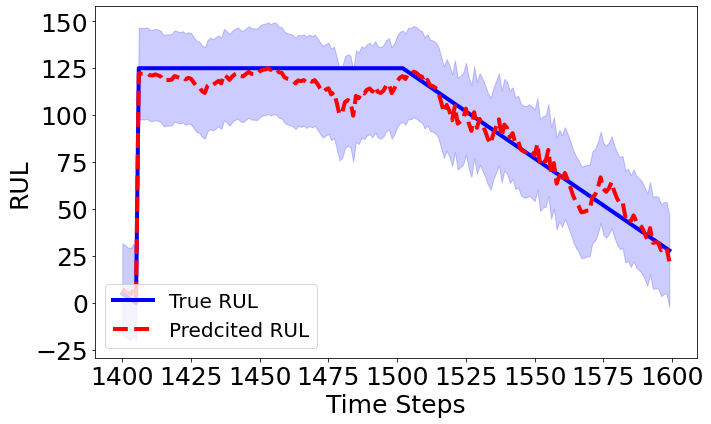

In [124]:
import os
#004 1150,1400
start =1400 #1900#1220 #0
end = 1600 #2060#1400 #len(test_rul)
x_tensor_test = torch.from_numpy(in_trainset.x[start:end]).to(torch.float32).to("cuda")
y_tensor_test = torch.Tensor([in_trainset.y[start:end]]).to(torch.float32).to("cuda")


if MODE == "DUE":
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
        predictions = model_test(x_tensor_test)
        ol = likelihood(predictions)
        mu = ol.mean
        output_std = ol.stddev**2
    #print(predictions.mean,likelihood.marginal(predictions).mean)   
    
if MODE == "Dropout":
    with torch.no_grad():
        predictions = model_test.predict(x_tensor_test)
        mu = predictions[0]
        output_std = predictions[1]*5e5


if MODE == "SNGP":
    mu, cov = model_test(x_tensor_test, None,return_cov=True)
    output_var = cov.diagonal()
    output_std = output_var.sqrt().cpu()

# criterion = torch.nn.MSELoss()
# loss_1 = criterion(y_tensor_test.ravel()*RUL_UPPER_THRESHOLD, mu.ravel()*RUL_UPPER_THRESHOLD)*len(y_tensor_test)
# loss_1 = (loss_1 / len(y_tensor_test)) ** 0.5
# print(loss_1)
fig= plt.figure(figsize=(10, 6))
plt.fill_between(range(start,end), 
                 mu.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD - output_std.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD, 
                 mu.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD + output_std.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD, 
                 alpha=0.2, color='b')
plt.plot(range(start,end), y_tensor_test.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD, c='b', label="True RUL", linewidth=4)
plt.plot(range(start,end), mu.cpu().detach().numpy()*RUL_UPPER_THRESHOLD, '--',  c='r', label="Predcited RUL",linewidth=4)
plt.xlabel("Time Steps", fontsize=25)
plt.ylabel("RUL", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc="lower left",fontsize=20)
plt.tight_layout()
#plt.savefig(os.path.join('./', f'image/USTAGNN_{IN_DATASET}_single.pdf'))

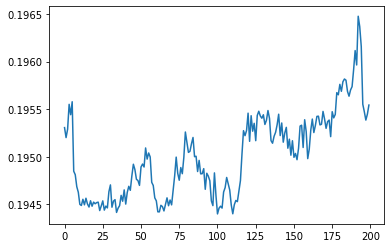

In [125]:
plt.plot(output_std.detach().cpu().numpy())

## plot prediction result for training set

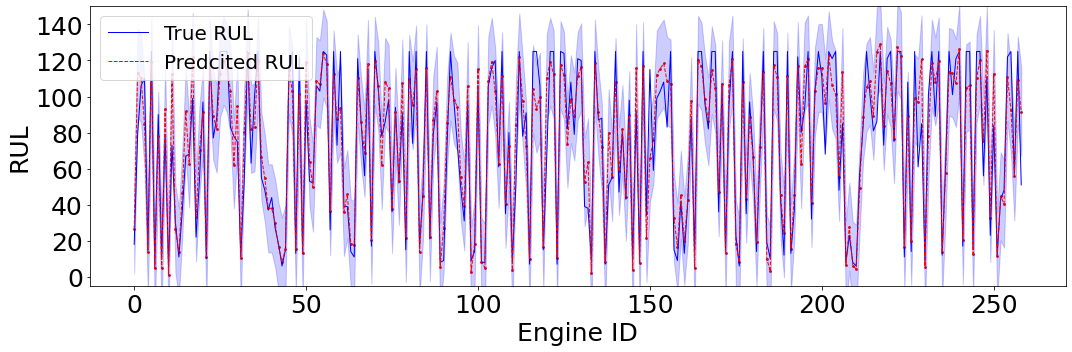

In [127]:
import os
#004 1150,1400
start =0 #1900#1220 #0
end = len(in_test_rul) #2060#1400 #len(test_rul)
x_tensor_test = torch.from_numpy(in_testset.x[start:end]).to(torch.float32).to("cuda")
y_tensor_test = torch.Tensor([in_testset.y[start:end]]).to(torch.float32).to("cuda")

if MODE == "DUE":
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
        predictions = model_test(x_tensor_test)
        ol = likelihood(predictions)
        mu = ol.mean
        output_std = ol.stddev**2
    #print(predictions.mean,likelihood.marginal(predictions).mean)   
    
if MODE == "Dropout":
    with torch.no_grad():
        predictions = model_test.predict(x_tensor_test)
        mu = predictions[0]
        output_std = predictions[1]*5e5

if MODE == "SNGP":
    mu, cov = model_test(x_tensor_test, None,return_cov=True)
    output_var = cov.diagonal()
    output_std = output_var.sqrt().cpu()
    
fig= plt.figure(figsize=(15, 5))
plt.plot(y_tensor_test.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD, c='b', label="True RUL", linewidth=1)
plt.plot(mu.cpu().detach().numpy()*RUL_UPPER_THRESHOLD, '--',  c='r', label="Predcited RUL",linewidth=1)
plt.scatter(range(start,end), mu.cpu().detach().numpy()*RUL_UPPER_THRESHOLD,c='r',s=3)
plt.fill_between(range(start,end), 
                 mu.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD - output_std.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD, 
                 mu.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD + output_std.cpu().detach().numpy().ravel()*RUL_UPPER_THRESHOLD, 
                 alpha=0.2, color='b')
plt.xlabel("Engine ID", fontsize=25)
plt.ylabel("RUL", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Test Result on {DATASET}",fontsize=20)
plt.legend(loc="upper left",fontsize=20)
plt.ylim(-5,150)
#plt.fill_between(range(0,220), (mu+sigma).cpu().detach().numpy().ravel(),(mu-sigma).cpu().detach().numpy().ravel(), alpha=0.2)
#plt.show()
plt.tight_layout()
#plt.savefig(os.path.join('./', f'image/USTAGNN_{IN_DATASET}.pdf'))

# OOD Test

In [128]:
def prepare_ood_datasets(true_dataset, ood_dataset):

    datasets = [true_dataset, ood_dataset]

    anomaly_targets = torch.cat(
        (torch.zeros(len(true_dataset)), torch.ones(len(ood_dataset)))
    )

    concat_datasets = torch.utils.data.ConcatDataset(datasets)

    dataloader = torch.utils.data.DataLoader(
        concat_datasets, batch_size=50, shuffle=False
    )

    return dataloader, anomaly_targets


def loop_over_dataloader(model, likelihood, dataloader):
    
    if MODE == "Dropout":
        model.train()
    else: 
        model.eval()

    if MODE == "DUE":
       model.likelihood.eval()

    with torch.no_grad():
        scores = []
        accuracies = []
        for data, _,target in dataloader:
            data = data.cuda()
            target = target.cuda()

            if MODE == "DUE":
                with gpytorch.settings.num_likelihood_samples(32):
                    y_pred = model(data)#.to_data_independent_dist()
                    ol = model.likelihood(y_pred)
                    output_mean = ol.mean*RUL_UPPER_THRESHOLD
                    output_std = ol.stddev*RUL_UPPER_THRESHOLD
                    uncertainty = output_std
                    
            if MODE == "Dropout":
                with torch.no_grad():
                    ol = model.predict(data)
                    output_mean = ol[0]*RUL_UPPER_THRESHOLD
                    uncertainty = ol[1]*RUL_UPPER_THRESHOLD
                
            if MODE == "SNGP":
                mu, cov = model(data, None,return_cov=True)
                output_var = cov.diagonal()
                uncertainty = output_var.sqrt().cpu()*RUL_UPPER_THRESHOLD 
                
            scores.append(uncertainty.cpu().numpy())

    scores = np.concatenate(scores)
    #accuracies = np.concatenate(accuracies)

    return scores, accuracies


def get_ood_metrics(in_dataset, out_dataset, model, likelihood=None):

    dataloader, anomaly_targets = prepare_ood_datasets(in_dataset, out_dataset)

    scores, accuracies = loop_over_dataloader(model, likelihood, dataloader)
    #print(len(scores))
    # accuracy = np.mean(accuracies[: len(in_dataset)])
    auroc = roc_auc_score(anomaly_targets, scores)
    
    precision, recall, _ = precision_recall_curve(anomaly_targets, scores)
    aupr = auc(recall, precision)
    print(auroc, aupr)
    return anomaly_targets, scores #accuracy, auroc, aupr

def gaussian_entropy(sigma):
    # 使用 PyTorch 计算高斯分布的熵
    return 0.5 * np.log(2 * np.pi * np.e * sigma ** 2)

In [129]:
out_testset_0 = copy.deepcopy(out_testset)
out_testset_0.x = out_testset_0.x
anomaly_targets, scores = get_ood_metrics(in_testset, out_testset_0, model, None)
entropy = gaussian_entropy(scores)

0.4775345622119816 0.5541091328578884


In [130]:
out_testset_01 = copy.deepcopy(out_testset)
out_testset_01.x = out_testset_01.x + 0.1
anomaly_targets_01, scores_01 = get_ood_metrics(in_testset, out_testset_01, model, None)
entropy_01 = gaussian_entropy(scores_01)

0.9981784780171876 0.9974409096271615


In [131]:
out_testset_02 = copy.deepcopy(out_testset)
out_testset_02.x = out_testset_02.x + 0.2
anomaly_targets_02, scores_02 = get_ood_metrics(in_testset, out_testset_02, model, None)
entropy_02 = gaussian_entropy(scores_02)

1.0 1.0


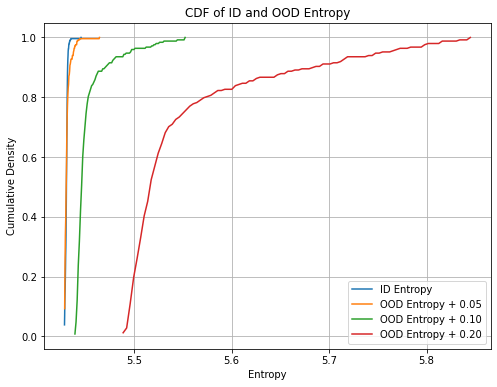

In [132]:
def compute_cdf(data):
    count, bin_edges = np.histogram(data, bins=100, density=True)
    cdf = np.cumsum(count * np.diff(bin_edges))
    return bin_edges[1:], cdf


id_entropy_0 = entropy[anomaly_targets==0]
ood_entropy_0 = entropy[anomaly_targets==1]
ood_entropy_01 = entropy_01[anomaly_targets==1]
ood_entropy_02 = entropy_02[anomaly_targets==1]
id_bin_edges, id_cdf = compute_cdf(id_entropy_0)
ood_bin_edges_0, ood_cdf_0 = compute_cdf(ood_entropy_0)
ood_bin_edges_01, ood_cdf_01 = compute_cdf(ood_entropy_01)
ood_bin_edges_02, ood_cdf_02 = compute_cdf(ood_entropy_02)

plt.figure(figsize=(8, 6))
plt.plot(id_bin_edges, id_cdf, label='ID Entropy')
plt.plot(ood_bin_edges_0, ood_cdf_0, label='OOD Entropy + 0.05')
plt.plot(ood_bin_edges_01, ood_cdf_01, label='OOD Entropy + 0.10')
plt.plot(ood_bin_edges_02, ood_cdf_02, label='OOD Entropy + 0.20')
plt.xlabel('Entropy')
plt.ylabel('Cumulative Density')
plt.title('CDF of ID and OOD Entropy')
plt.legend()
plt.grid(True)
plt.show()

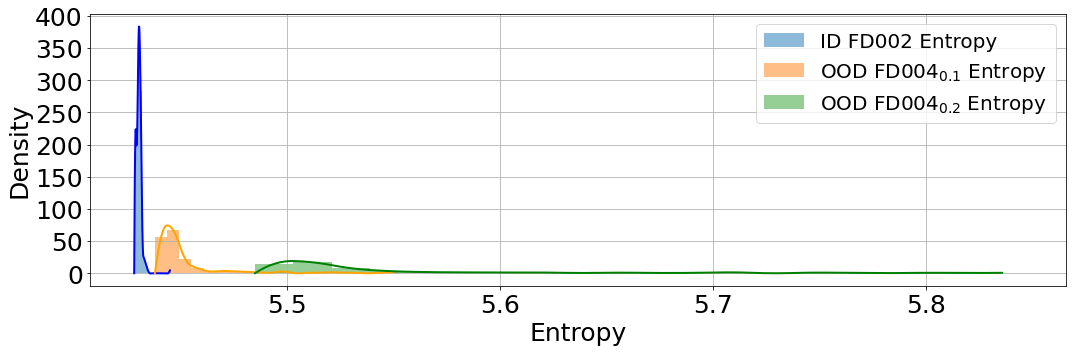

In [133]:
from scipy.stats import norm
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as ticker
import os
if MODE == "Dropout":
   bins=10
else:
   bins=20 

id_counts, id_bins = np.histogram(id_entropy_0, bins=bins, density=True)
ood_counts_0, ood_bins_0 = np.histogram(ood_entropy_0, bins=bins, density=True)
ood_counts_01, ood_bins_01 = np.histogram(ood_entropy_01, bins=bins, density=True)
ood_counts_02, ood_bins_02 = np.histogram(ood_entropy_02, bins=bins, density=True)



plt.figure(figsize=(15, 5))
plt.hist(id_entropy_0, bins=bins, alpha=0.5, label='ID FD002 Entropy', density=True)
#plt.hist(ood_entropy_0, bins=100, alpha=0.5, label='OOD Entropy 0', density=True)
plt.hist(ood_entropy_01, bins=bins, alpha=0.5, label='OOD FD004$_{0.1}$ Entropy', density=True)
plt.hist(ood_entropy_02, bins=bins, alpha=0.5, label='OOD FD004$_{0.2}$ Entropy', density=True)


id_bin_centers = (id_bins[:-1] + id_bins[1:]) / 2
id_bin_centers = np.insert(id_bin_centers, 0, id_bins[0])
ood_bin_centers_0 = (ood_bins_0[:-1] + ood_bins_0[1:]) / 2
ood_bin_centers_0 = np.insert(ood_bin_centers_0, 0, ood_bins_0[0])
ood_bin_centers_01 = (ood_bins_01[:-1] + ood_bins_01[1:]) / 2
ood_bin_centers_01 = np.insert(ood_bin_centers_01, 0, ood_bins_01[0])
ood_bin_centers_02 = (ood_bins_02[:-1] + ood_bins_02[1:]) / 2
ood_bin_centers_02 = np.insert(ood_bin_centers_02, 0, ood_bins_02[0])

spl = make_interp_spline(id_bin_centers, np.insert(id_counts, 0, 0), k=2)  # k是平滑度
smooth_id_bin_centers = np.linspace(id_bin_centers.min(), id_bin_centers.max(), 300)
smooth_id_hist = spl(smooth_id_bin_centers)

spl_01 = make_interp_spline(ood_bin_centers_01, np.insert(ood_counts_01, 0, 0), k=2)  # k是平滑度
smooth_ood_bin_centers_01 = np.linspace(ood_bin_centers_01.min(), ood_bin_centers_01.max(), 300)
smooth_ood_hist_01 = spl_01(smooth_ood_bin_centers_01)

spl_02 = make_interp_spline(ood_bin_centers_02, np.insert(ood_counts_02, 0, 0), k=2)  # k是平滑度
smooth_ood_bin_centers_02 = np.linspace(ood_bin_centers_02.min(), ood_bin_centers_02.max(), 300)
smooth_ood_hist_02 = spl_02(smooth_ood_bin_centers_02)


plt.plot(smooth_id_bin_centers, smooth_id_hist, 'b', linewidth=2)
plt.plot(smooth_ood_bin_centers_01, smooth_ood_hist_01, 'orange', linewidth=2)
plt.plot(smooth_ood_bin_centers_02, smooth_ood_hist_02, 'g', linewidth=2)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Entropy',fontsize=25)
plt.ylabel('Density',fontsize=25)
#plt.xlim((5.65, 6))
left, right = plt.xlim()
#plt.xlim(left, 5.13)
#formatter = ticker.FormatStrFormatter('%.1f')
#plt.gca().xaxis.set_major_formatter(formatter)

#plt.ylim((0, 100))
#plt.title('OOD Test for DKGP Method')
plt.legend(loc="upper right", fontsize=20)
plt.grid(True)
plt.tight_layout()
#plt.savefig(os.path.join('./', f'image/{MODE}_OOD.pdf'))

#plt.show()

## Hidden feature visualization

In [134]:
from sklearn.manifold import TSNE
x_tensor_1 = torch.from_numpy(in_trainset.x[:100]).to(torch.float32).to("cuda")
y_tensor_1 = torch.Tensor([in_trainset.y[:100]]).to(torch.float32).to("cuda")
p, f = model_test.feature_extractor.forward(x_tensor_1, None, True)

In [135]:
def visualize(h, color, rul, random_state=10):
    #fig, axs = plt.subplots(1,2, figsize=(20,10))
    fig = plt.figure(figsize=(5,8))
    cm = plt.get_cmap('gist_rainbow')
    plt.xticks([])
    plt.yticks([])
    h = h.reshape(100,-1)

    z = TSNE(n_components=2, perplexity=30,  random_state=random_state).fit_transform(h.detach().cpu().numpy())

    # sc = axs[1].scatter(z[:, 0], z[:, 1], s=rul[:]*300+30, c=rul[:]*125, alpha=1, cmap='Blues')
    steps = [3,8,15,20, 30,45,55,65, 78,85,95,99]
    plt.plot(z[steps, 0], z[steps, 1], '-') 
    plt.quiver(z[steps[:-1], 0], z[steps[:-1], 1],z[steps[1:], 0]-z[steps[:-1], 0], z[steps[1:], 1]-z[steps[:-1], 1])
    sc = plt.scatter(z[:, 0], z[:, 1], s=rul[:]*300+30, c=rul[:]*125, alpha=1, cmap='gist_rainbow')
    cbar = plt.colorbar(sc)
    cbar.set_label('RUL', rotation=270)
    #plt.show()
    plt.tight_layout()
    #plt.savefig(os.path.join('./', f'image/t-SNE_Visualization1.pdf'))

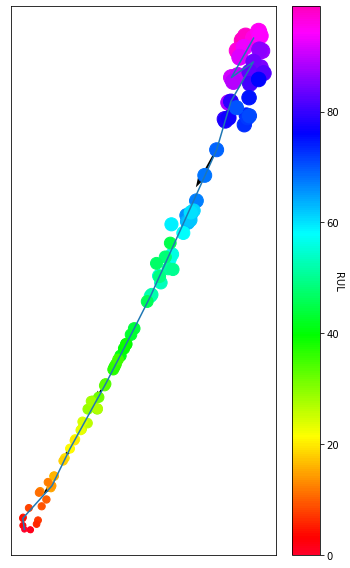

In [136]:
#visualize(f.permute(0, 2, 1), range(24), y_tensor_1.detach().cpu().numpy().ravel(), random_state=24)
visualize(f, range(24), y_tensor_1.detach().cpu().numpy().ravel(), random_state=24)

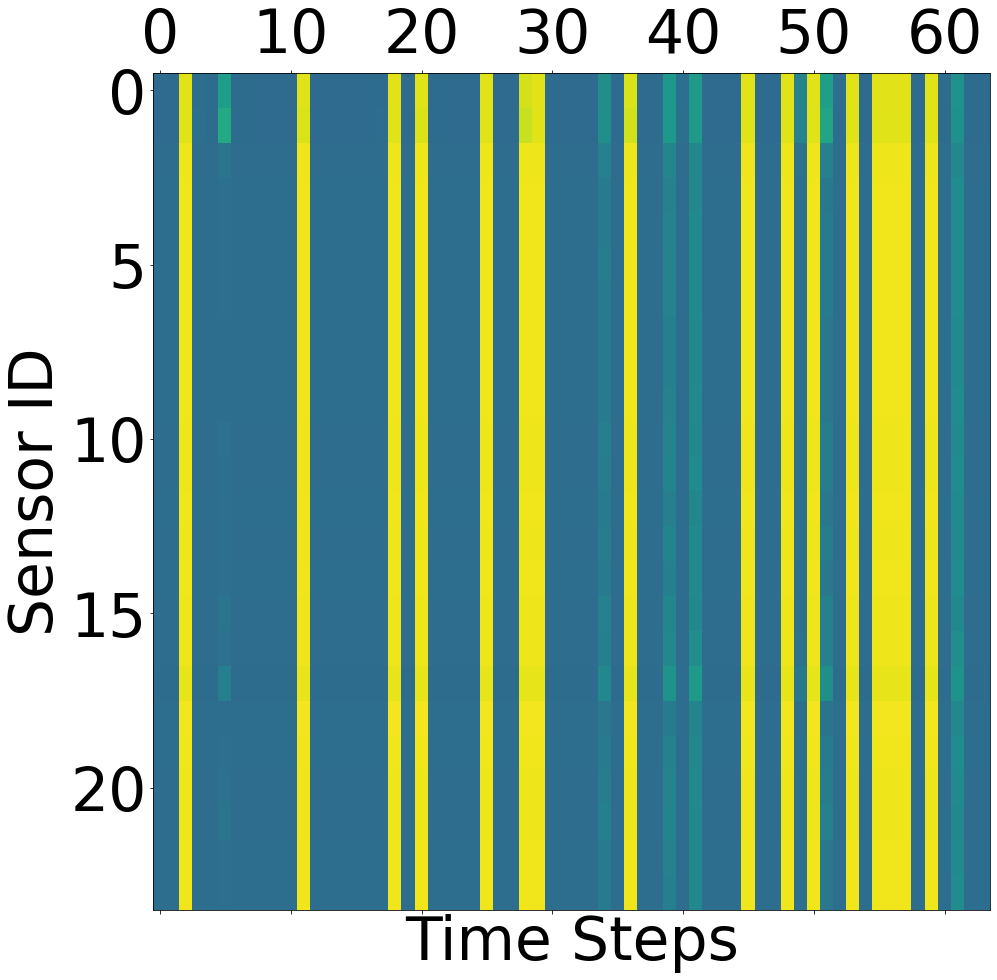

In [137]:
temproal_att = model_test.feature_extractor.tcn.network[1].x_probs[5].T
fig = plt.figure(figsize=(15,15))
plt.matshow(temproal_att.cpu().detach().numpy(), vmin=0, vmax=0.03, fignum=1, aspect='auto')
plt.xlabel("Time Steps", fontsize=60)
plt.ylabel("Sensor ID", fontsize=60)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.tight_layout()